In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [93]:
class GMM():
    def __init__(self, n_components, data):
        self.num_data = data.shape[0]
        self.dimension = data.shape[1]
        self.data = data
        self.components = n_components
        self.means = self.initialize_means()
        self.covariances = self.initialize_variances()
        self.lambdas = self.initialize_lambdas()
        
#         self.gammas = self.initialize_gammas()
#         self.means = self.calculate_means()
#         self.covariances = self.calculate_variances()
#         self.lambdas = self.calculate_lambdas()
    
    
    def initialize_means(self): 
        random_choice = np.random.choice(self.num_data, self.components, replace = False)
        means_ = self.data[random_choice]
        return means_
        
    def initialize_variances(self):
        covariances_ = np.zeros((self.components, self.dimension, self.dimension))
        for i in range(self.components):
            covariances_[i] = np.cov(self.data, rowvar = False)
        return covariances_    
    
    def initialize_lambdas(self):
        return np.ones([self.components]) / float(self.components)
        
        
    def initialize_gammas(self):
        """Initializes gammas to random values maintaining their sum = 1 for each component"""
        gammas_ = np.random.rand(self.components, self.num_data)
        gammas_ = gammas_ / gammas_.sum(0)
        return gammas_
        
    def calculate_means(self):
        """Calculates the means based on the current values of gammas"""
#         print(self.num_data, self.components, self.dimension)
        means_ = np.zeros((self.components, self.dimension))
        for i in range(self.components):
            for j in range(self.num_data):
                means_[i] += self.gammas[i][j] * self.data[j] / self.gammas[i].sum()
        return means_
        
    def calculate_variances(self):
        """Calculates the covariances based on the current values of gammas"""

        covariances_ = np.zeros((self.components, self.dimension, self.dimension))
        for i in range(self.components):
            for j in range(self.num_data):
                covariances_[i] += self.gammas[i][j] * np.dot((self.data[j] - self.means[i]).reshape(-1, 1), (self.data[j] - self.means[i]).reshape(-1, 1).T) / self.gammas[i].sum()
        return covariances_
    
    def calculate_lambdas(self):
        """Updates lambdas based on the values of gamma"""
        return self.gammas.sum(1)/self.gammas.sum()
    
    def calculate_gammas(self):
        """Updates gammas based on the values of the means, covariances and lambdas"""
        gammas_ = np.zeros((self.components, self.num_data))
        for i in range(self.components):
            for j in range(self.num_data):
                gammas_[i, j] = self.lambdas[i] * self.gaussian_probability(self.data[j], self.means[i], self.covariances[i])
        gammas_ = gammas_ / gammas_.sum(0)
        return gammas_
    
    def calculate_likelihood(self):
        """Calculates the likelihood of data given parameters. We need to stop EM when likelihood saturates"""
        prb = np.zeros((self.num_data))
        for j in range(self.num_data):
            for i in range(self.components):
                prb[j] += self.lambdas[i] * self.gaussian_probability(self.data[j], self.means[i], self.covariances[i])
        likelihood_ = np.sum(np.log(prb))
        print("Likelihood {}".format(likelihood_))
        return likelihood_
    
    def gaussian_probability(self, x_, mu_, sigma_):
        """Given the datapoint, mean for the component and the variance matrix of the component, calculates the probability"""
        x_ = x_.reshape(-1, 1)
        mu_ = mu_.reshape(-1, 1)

        prob_ = (1. / (np.power(2 * np.pi, self.dimension / 2.) * np.power(np.linalg.det(sigma_), 0.5))) * np.exp(- 0.5 * np.dot((x_ - mu_).T, np.dot(np.linalg.inv(sigma_), (x_ - mu_))))
        prob_ = float(prob_.reshape(1))
#         print(prob_)
        return prob_

    def EM(self):
        likelihood_list = []
        for i in range(100):
            self.gammas = self.calculate_gammas() # E STEP
            self.means = self.calculate_means() # M STEP
            self.covariances = self.calculate_variances() # M STEP
            self.lambdas = self.calculate_lambdas() # M STEP
            likelihood_list.append(self.calculate_likelihood()) #CALCULATE LIKELIHOOD
            if len(likelihood_list) > 10 and likelihood_list[-3] == likelihood_list[-1]:
                break
        return likelihood_list

### Data Preparation and Initialization

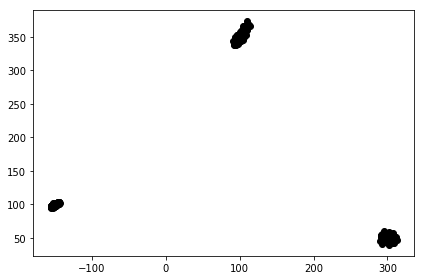

In [94]:
def generate_data(n_data, means, covariances, weights):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    data = np.zeros((n_data, n_features))
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data[i] = x
   
    return data


# Model parameters, including the mean
# covariance matrix and the weights for each cluster
init_means = np.array([
    [300, 50],
    [-150, 100],
    [100, 350]
])

init_covariances = np.array([
    [[28.5, 0.], [0, 12.5]],
    [[5.92, 3.38], [3.38, 2.91]],
    [[25.5, 30.2], [30.2, 55.5]]
])

init_weights = [.25, .5, .25]

# generate data
# np.random.seed(4)
X = generate_data(500, init_means, init_covariances, init_weights)

plt.plot(X[:, 0], X[:, 1], 'ko')
plt.tight_layout()
plt.show()

### Initializing Model on the Data

In [104]:
mod = GMM(3, X)

### Initial Parameters of the model

In [105]:
mod.covariances

array([[[ 35047.93861537,   1873.80137722],
        [  1873.80137722,  13761.40624636]],

       [[ 35047.93861537,   1873.80137722],
        [  1873.80137722,  13761.40624636]],

       [[ 35047.93861537,   1873.80137722],
        [  1873.80137722,  13761.40624636]]])

In [106]:
mod.means

array([[-147.20357109,  100.82838927],
       [ 113.83756302,  366.00564723],
       [ 109.78060932,  373.78174928]])

In [107]:
mod.lambdas

array([ 0.33333333,  0.33333333,  0.33333333])

### Running EM on the GMM

Log Likelihoods in every iteration are printed

In [108]:
likelihoods = mod.EM()

Likelihood -5872.91518523
Likelihood -4925.82388049
Likelihood -4774.85884213
Likelihood -4475.75372426
Likelihood -4430.76820845
Likelihood -4385.56651907
Likelihood -4160.75132808
Likelihood -3889.28087061
Likelihood -2956.25243032
Likelihood -2896.70075029
Likelihood -2896.70075029
Likelihood -2896.70075029


# 

In [101]:
mod.covariances

array([[[ 27.18011991,  -0.1766273 ],
        [ -0.1766273 ,  14.20339821]],

       [[  6.16200767,   3.29126623],
        [  3.29126623,   2.87931373]],

       [[ 21.80951979,  27.80218181],
        [ 27.80218181,  52.18668519]]])

In [102]:
mod.lambdas

array([ 0.234,  0.518,  0.248])

In [103]:
mod.means

array([[ 300.37304351,   49.78891622],
       [-149.98033461,   99.89445408],
       [ 100.51627925,  351.46717122]])